In [2]:
from pennylane import numpy as np
import pennylane as qml
from matplotlib import pyplot as plt
import skquant.opt as skqopt #optimization routines
from scipy.linalg import expm
from Functionals import *

In [2]:
# matrix representation of Toffoli gate
U = np.array([[1,0,0,0,0,0,0,0],[0,1,0,0,0,0,0,0],[0,0,1,0,0,0,0,0],[0,0,0,1,0,0,0,0],[0,0,0,0,1,0,0,0],[0,0,0,0,0,1,0,0],
                  [0,0,0,0,0,0,0,1],[0,0,0,0,0,0,1,0]])

print(U)

[[1 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0]
 [0 0 0 1 0 0 0 0]
 [0 0 0 0 1 0 0 0]
 [0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 1 0]]


In [3]:
I = np.eye(2)
X = np.array([[0, 1], [1, 0]])
Z = np.array([[1, 0], [0, -1]])
Y = np.array([[0,-1j],[1j, 0]])

In [4]:
H=[np.kron(np.kron(I,I),I),np.kron(np.kron(I,I),Z),np.kron(np.kron(Z,I),Z),np.kron(np.kron(I,Z),Z),
   np.kron(np.kron(X,X),I),np.kron(np.kron(Y,Y),I),np.kron(np.kron(Z,Z),I),np.kron(np.kron(Z,I),I),
   np.kron(np.kron(I,Z),I),np.kron(np.kron(I,I),X),np.kron(np.kron(I,X),I),np.kron(np.kron(X,I),I),
   np.kron(np.kron(X,I),X),np.kron(np.kron(I,X),X)]


In [5]:
comm_terms=ham_grouping(H)[0]
len(comm_terms)

62

In [6]:
comm_terms

[[0, 1],
 [0, 2],
 [0, 3],
 [0, 4],
 [0, 5],
 [0, 6],
 [0, 7],
 [0, 8],
 [0, 9],
 [0, 10],
 [0, 11],
 [0, 12],
 [0, 13],
 [1, 2],
 [1, 3],
 [1, 4],
 [1, 5],
 [1, 6],
 [1, 7],
 [1, 8],
 [1, 10],
 [1, 11],
 [2, 3],
 [2, 6],
 [2, 7],
 [2, 8],
 [2, 10],
 [2, 12],
 [3, 6],
 [3, 7],
 [3, 8],
 [3, 11],
 [3, 13],
 [4, 5],
 [4, 6],
 [4, 9],
 [4, 10],
 [4, 11],
 [4, 12],
 [4, 13],
 [5, 6],
 [5, 9],
 [6, 7],
 [6, 8],
 [6, 9],
 [7, 8],
 [7, 9],
 [7, 10],
 [7, 13],
 [8, 9],
 [8, 11],
 [8, 12],
 [9, 10],
 [9, 11],
 [9, 12],
 [9, 13],
 [10, 11],
 [10, 12],
 [10, 13],
 [11, 12],
 [11, 13],
 [12, 13]]

In [7]:
len(ham_grouping(H)[1])

29

In [8]:
62+29*2

120

In [9]:
opt_par=np.array([ 0.77371757,  0.        ,  0.        ,  0.        ,  0.07125842,
        0.07125842,  0.78539816,  2.3547277 , -0.78393137,  2.74889357,
        3.10517936,  1.08810061,  1.08810061,  3.10517936])
opt_par*2

tensor([ 1.54743514,  0.        ,  0.        ,  0.        ,  0.14251684,
         0.14251684,  1.57079632,  4.7094554 , -1.56786274,  5.49778714,
         6.21035872,  2.17620122,  2.17620122,  6.21035872], requires_grad=True)

In [10]:
dev = qml.device("default.qubit", wires=3)


#@qml.qnode(dev)
def ansatz(params):
    l=params

    
    #H=Z⊗Z⊗I
    qml.CNOT(wires=[0,1])
    qml.RZ(l[0],wires=1)
    qml.CNOT(wires=[0,1])
    
    
    #Z⊗I⊗I
    qml.RZ(l[1],wires=0)
   
    #I⊗Z⊗I
    qml.RZ(l[2],wires=1)
    
    
    #I⊗I⊗X
    qml.RX(l[3],wires=2)
    
    #I⊗X⊗I
    qml.RX(l[4],wires=1)
    
    #X⊗I⊗I
    qml.RX(l[5],wires=0)
    
    # circuit for local ham H=X⊗I⊗X
    qml.Hadamard(wires=0)
    qml.Hadamard(wires=2)
    qml.CNOT(wires=[0,2])
    qml.RZ(l[6],wires=2)
    qml.CNOT(wires=[0,2])
    qml.Hadamard(wires=0)
    qml.Hadamard(wires=2)
    
    
    # circuit for local ham H=I⊗X⊗X
    [qml.Hadamard(wires=i) for i in range(1,3)]
    qml.CNOT(wires=[1,2])
    qml.RZ(l[7],wires=2)
    qml.CNOT(wires=[1,2])
    [qml.Hadamard(wires=i) for i in range(1,3)]
    

In [11]:
Trotter_steps=6

In [12]:
@qml.qnode(dev)
#@qml.transforms.insert(qml.PhaseFlip, 0.2, position="end") # add noise when needed using "qml.transforms.insert"
def circuit(params, state, apply_inv=True):
    qml.BasisState(np.array(state), wires=[0,1,2])
  
    for d in range(Trotter_steps):
        ansatz(params[:13])
    

    return qml.state()

def var_circ(params,state):
    result=(np.exp(-1j*params[0])*circuit(params[1:],state))
    
    return result

In [13]:
@qml.qnode(dev, diff_method="backprop")
def target_st(state):
    qml.BasisState(np.array(state), wires=[0,1,2])
    qml.QubitUnitary(U,wires=[0,1,2]).inv() # fredkin gate
    return qml.state()

In [14]:
def get_unitary(params):
    return np.array([circuit(params, state) for state in state_vector]).T

In [15]:
# 1st cost => the overlaps between target and variational kets are taken as cost : can be obtained using Hadamard test
def cost3(params): # more general cost function
    circ_ket=[]
    act_ket=[]
    overlaps=[] 
        
    for i in range(8):
        state=state_vector[i]
        circ_ket.append(circuit(params,state))
        act_ket.append(target_st(state))

        overlaps.append((np.sum(np.dot(np.conj(circ_ket[i]),act_ket[i]))))
    cost=0
    for i in range(8):
        cost+=(overlaps[i])
    cost_abs=1-(np.abs(cost)/len(overlaps))**2   
    return cost_abs#, overlaps

In [16]:
# 2nd cost the trace distance between two unitaries is taken as cost : can be obtained using Hilber-Schimdt test
def cost1(params):
    U_par=get_unitary(params)
    F=(np.abs(np.trace(np.dot(np.transpose(np.conj(U_par)),U)))/len(U))**2
    
    return 1-F

In [17]:
params = np.random.random(14)
Id = np.eye(8, requires_grad=False)
state_vector=np.array([[0,0,0],[0,0,1],[0,1,0],[0,1,1],[1,0,0],[1,0,1],[1,1,0],[1,1,1]])
print(Id[7])
print(state_vector[7])

[0. 0. 0. 0. 0. 0. 0. 1.]
[1 1 1]


In [18]:
init_p=np.array([ 0.00148046,  0.53702133, -0.06340707,  0.6037491 ,  0.528633  ,
         1.03121218,  0.86660951,  0.49076635,  0.31136971,  0.85875153,
         0.93465599,  0.71024208,  0.05872529,  0.27780705])
params=init_p

In [19]:
cost3(init_p)

0.6941018170372688

In [306]:
par_arr=[]
def func_par():
    param=np.random.random(10)
    print("cost-->",cost3(param))
    par_arr.append(param)
    if cost3(param)>0.6:
        func_par()
    
    return par_arr

In [307]:
params=func_par()

cost--> 0.996582333215273
cost--> 0.961239913699666
cost--> 0.9621532614288903
cost--> 0.9035463228144658
cost--> 0.9768893149955524
cost--> 0.8581107443706382
cost--> 0.736641513315514
cost--> 0.9514092956772229
cost--> 0.881572473197313
cost--> 0.886405886848984
cost--> 0.9849187606832783
cost--> 0.937475622703708
cost--> 0.9064220002964669
cost--> 0.9603902965016329
cost--> 0.9693865464424396
cost--> 0.91004014433797
cost--> 0.9251018241793971
cost--> 0.8328221151875013
cost--> 0.9576713900050179
cost--> 0.9654439962804571
cost--> 0.9970523494990979
cost--> 0.9603413441281811
cost--> 0.9878880796825769
cost--> 0.956300597807953
cost--> 0.9565109957483434
cost--> 0.7610382170537574
cost--> 0.946202624250476
cost--> 0.8685051182156138
cost--> 0.8946301612633235
cost--> 0.9150032206975693
cost--> 0.9706692444951134
cost--> 0.8009640713068877
cost--> 0.9815288565685335
cost--> 0.9719443521650026
cost--> 0.9571117547576404
cost--> 0.9783800344840773
cost--> 0.9961037440426802
cost--> 0.9

In [308]:
params=(params[-1])

In [318]:
params

tensor([0.39188592, 0.6163197 , 0.59069602, 0.95306003, 0.44948882,
        0.18846414, 0.50966215, 0.40795083, 0.67857546, 0.83198497], requires_grad=True)

In [34]:
cost_arr=[]
params_arr=[]
cost_arr_opt=[]
params_arr_opt=[]

In [35]:
def optimization2(params,st):
    dev = qml.device("default.qubit.autograd", wires=3)

    opt = qml.AdagradOptimizer(stepsize=st)
    
    
    for i in range(200+1):
        params = opt.step(cost1, params)
        cost_arr.append(cost1(params))
        params_arr.append(params)
        if i % 10 == 0:
            print(f"Cost at step {i}:", cost1(params))
            
            print(f"fidelity of natural dynamics with actual toffoli{i}:",Fidelity(hamiltonian_matrix(params*3),U))
            
    if cost1(params)>0.001:
        params=np.random.random(14)
    if Fidelity(hamiltonian_matrix(params*3),U)<0.997:
        st=np.random.uniform(0.01,0.2)
        optimization2(params,st)
        
    else:
        
        
        for i in range(0,10+1,1):
            print(f"Cost at step {i*10}:", cost1(params_arr[len(cost_arr)-11+i]))
            cost_arr_opt.append(cost1(params_arr[len(cost_arr)-11+i]))
            params_arr_opt.append(params_arr[len(cost_arr)-11+i])
            
    return params_arr_opt,st

In [36]:
optimization2(params,0.1) # st=learning rate==stepsize

Cost at step 0: 0.4911750696008489
fidelity of natural dynamics with actual toffoli0: 0.7096534467307274
Cost at step 10: 0.0008935430618675078
fidelity of natural dynamics with actual toffoli10: 0.9981772785635705
Cost at step 20: 0.00011794410732268723
fidelity of natural dynamics with actual toffoli20: 0.9992170573192987
Cost at step 30: 9.41849398744532e-05
fidelity of natural dynamics with actual toffoli30: 0.9993431445462573
Cost at step 40: 9.363948702156843e-05
fidelity of natural dynamics with actual toffoli40: 0.9993606597829766
Cost at step 50: 9.362704961390911e-05
fidelity of natural dynamics with actual toffoli50: 0.9993632682101481
Cost at step 60: 9.36267660588408e-05
fidelity of natural dynamics with actual toffoli60: 0.9993636612327351
Cost at step 70: 9.362675959345701e-05
fidelity of natural dynamics with actual toffoli70: 0.9993637205572073
Cost at step 80: 9.362675944313281e-05
fidelity of natural dynamics with actual toffoli80: 0.9993637295143175
Cost at step 90:

([tensor([-0.26171905,  0.26171905,  0.26171905,  0.65449847,  0.51577568,
           1.03475037,  1.03475037,  0.51577568,  0.31136971,  0.85875153,
           0.93465599,  0.71024208,  0.05872529,  0.27780705], requires_grad=True),
  tensor([-0.26171905,  0.26171905,  0.26171905,  0.65449847,  0.51577568,
           1.03475037,  1.03475037,  0.51577568,  0.31136971,  0.85875153,
           0.93465599,  0.71024208,  0.05872529,  0.27780705], requires_grad=True),
  tensor([-0.26171905,  0.26171905,  0.26171905,  0.65449847,  0.51577568,
           1.03475037,  1.03475037,  0.51577568,  0.31136971,  0.85875153,
           0.93465599,  0.71024208,  0.05872529,  0.27780705], requires_grad=True),
  tensor([-0.26171905,  0.26171905,  0.26171905,  0.65449847,  0.51577568,
           1.03475037,  1.03475037,  0.51577568,  0.31136971,  0.85875153,
           0.93465599,  0.71024208,  0.05872529,  0.27780705], requires_grad=True),
  tensor([-0.26171905,  0.26171905,  0.26171905,  0.65449847,  0

In [38]:
len(cost_arr)

201

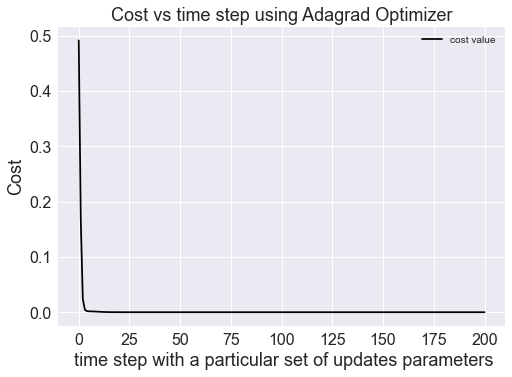

In [37]:
x=np.linspace(0,200,len(cost_arr))
y=cost_arr
plt.plot(x,y,"black",label="cost value")
plt.title("Cost vs time step using Adagrad Optimizer", fontsize=18)
plt.ylabel("Cost", fontsize=18)
plt.xlabel(" time step with a particular set of updates parameters", fontsize=18)
plt.tick_params(axis="both", which="major", labelsize=16)   # helps to increase the size of the values in X and Y axis
plt.tick_params(axis="both", which="minor", labelsize=16)
plt.legend()
plt.show()

In [ ]:
x=np.linspace(0,200,len(cost_arr))
y=paramsarr
plt.plot(x,y)
plt.ylabel("values of the Parameter", fontsize=18)
plt.xlabel("At time step", fontsize=18)
plt.title("Evolution of the parameters using AdagradOptimizer", fontsize=18)
plt.tick_params(axis="both", which="major", labelsize=16)   # helps to increase the size of the values in X and Y axis
plt.tick_params(axis="both", which="minor", labelsize=16)
plt.legend()
plt.show()

In [25]:
H=[np.kron(np.kron(Z,Z),I),np.kron(np.kron(Z,I),I),
   np.kron(np.kron(I,Z),I),np.kron(np.kron(I,I),X),np.kron(np.kron(I,X),I),np.kron(np.kron(X,I),I),
   np.kron(np.kron(X,I),X),np.kron(np.kron(I,X),X)]

print("No of commuting terms",len(ham_grouping(H)[0]))
print("No of anti-commuting terms",len(ham_grouping(H)[1]))

No of commuting terms 20
No of anti-commuting terms 8


In [26]:
def hamiltonian_matrix(params):
    l=params
    H=  l[0]*np.kron(np.kron(Z,Z),I) + l[1]*np.kron(np.kron(Z,I),I) + \
        l[2]*np.kron(np.kron(I,Z),I) + l[3]*np.kron(np.kron(I,I),X) + \
        l[4]*np.kron(np.kron(I,X),I) + l[5]*np.kron(np.kron(X,I),I) + l[6]*np.kron(np.kron(X,I),X) + \
       l[7]*np.kron(np.kron(I,X),X)
    
    return expm(-1j*H)

In [27]:
# Function to find the fidelity between two unitaries
def Fidelity(rho1,rho2):
    if rho1.shape!=rho2.shape:
        raise ValueError("Dimension of both matrices must be same")
    return (np.abs(np.trace(np.dot(np.transpose(np.conj(rho1)),rho2)))/len(rho1))

In [276]:
opt_par=np.array([ 0.78539816,  2.3547277 , -0.78393137,  2.74889357,
        3.10517936,  1.08810061,  1.08810061,  3.10517936])

In [317]:
Fidelity(hamiltonian_matrix(params_arr[len(params_arr)-1]*3),U)

0.999363731107289

In [313]:
print("cost:-",cost1(params_arr[len(params_arr)-1]))
#params_arr[len(params_arr)-18]
print("optimal parameters",params_arr[len(params_arr)-1]*3)

cost:- 9.362675944024623e-05
optimal parameters [-0.78515716  0.78515716  0.78515716  1.96349541  1.54732704  3.1042511
  3.1042511   1.54732704  0.93410913  2.57625459  2.80396796  2.13072625
  0.17617587  0.83342116]


In [315]:
rho1=hamiltonian_matrix(params_arr[len(params_arr)-1]*3)

'''
hamiltonian_matrix([ 14.70680597,  2.93760421,  1.50054604,  1.6154871 ,  3.10889122,
        3.09924546,  9.02167293,  1.88011837,  2.1182022 ,  1.50551024,
       -0.13108176, -0.16354886, -0.1107321 , -0.2536832]) gives fidelity 0.989< 0.998
        
'''
'''      
    hamiltonian_matrix([4.79193262e-01, -3.29973536e-27,  1.80393235e-23,
        -2.30258500e-27,  7.12584165e-02,  7.12584165e-02,
         7.85398163e-01,  2.35472770e+00, -7.83931374e-01,
         2.74889357e+00,  3.10517936e+00,  1.08810061e+00,
         1.08810061e+00,  3.10517936e+00]) #=result=optimized parameters Gives fidelity=0.999
'''
rho2=U
print("Fidelity between the actual Toffoli and the optimized Toffoli",Fidelity(rho2,(rho1)))
#print((rho1))
print("The exact e^(-iHt) using optimal parameters obtained from the quantum circuit \n",(rho1))

Fidelity between the actual Toffoli and the optimized Toffoli 0.999363731107289
The exact e^(-iHt) using optimal parameters obtained from the quantum circuit 
 [[ 0.38529875+0.92227374j  0.00283798-0.00169799j  0.00850577-0.00310429j
   0.00850577-0.00310429j  0.01475026-0.00595103j  0.01475026-0.00595103j
  -0.01100106+0.0040677j  -0.01100106+0.0040677j ]
 [ 0.00283798-0.00169799j  0.38529875+0.92227374j  0.00850577-0.00310429j
   0.00850577-0.00310429j  0.01475026-0.00595103j  0.01475026-0.00595103j
  -0.01100106+0.0040677j  -0.01100106+0.0040677j ]
 [ 0.00850577-0.00310429j  0.00850577-0.00310429j  0.38451997+0.9223669j
   0.0020592 -0.00160483j -0.01061287+0.00402126j -0.01061287+0.00402126j
   0.0203325 -0.0080151j   0.0203325 -0.0080151j ]
 [ 0.00850577-0.00310429j  0.00850577-0.00310429j  0.0020592 -0.00160483j
   0.38451997+0.9223669j  -0.01061287+0.00402126j -0.01061287+0.00402126j
   0.0203325 -0.0080151j   0.0203325 -0.0080151j ]
 [ 0.01475026-0.00595103j  0.01475026-0.00595

In [331]:
cost_arr

[0.31983658453281494,
 0.08175799473919221,
 0.08171836662479048,
 0.08171835664818705,
 0.08171835664090366,
 0.08171835664083449,
 0.08171835664083471,
 0.08171835664083471,
 0.08171835664083416,
 0.08171835664083471,
 0.08171835664083349,
 0.08171835664083116,
 0.08171835664083116,
 0.08171835664083194,
 0.08171835664083194,
 0.0817183566408316,
 0.0817183566408316,
 0.0817183566408316,
 0.0817183566408316,
 0.08171835664083194,
 0.0817183566408316,
 0.8377226310983352,
 0.09496348683829925,
 0.09165254105832132,
 0.09156758860950553,
 0.09156571221484211,
 0.09156567093602319,
 0.09156567002794547,
 0.09156567000796756,
 0.09156567000752847,
 0.09156567000752192,
 0.09156567000751725,
 0.09156567000751803,
 0.09156567000751914,
 0.09156567000751781,
 0.09156567000751825,
 0.09156567000751892,
 0.09156567000751892,
 0.09156567000751781,
 0.09156567000751914,
 0.09156567000751825,
 0.0915656700075198,
 0.6941018216520622,
 0.0006169500545315509,
 0.0001225244967224537,
 9.47103159190

In [330]:
cost_arr[0] # initial value at 1st epoch

0.31983658453281494

In [338]:
params_arr[0]

tensor([0.29188592, 0.7163197 , 0.69069602, 0.85306003, 0.3494891 ,
        0.28846414, 0.60966213, 0.30795168, 0.67857546, 0.83198497], requires_grad=True)

In [332]:
cost_arr[21] # initial value at 2nd epoch

0.8377226310983352

In [339]:
params_arr[21]

tensor([ 0.12526996,  0.96921227,  0.63007378, -0.04850227,  0.75025811,
         0.83928215,  1.02698269,  0.78034692,  0.08723125,  0.54601563,
         0.8943987 ,  0.13124939,  0.57588645,  0.11552289], requires_grad=True)

In [334]:
cost_arr[42] # initial value at 3rd epoch

0.6941018216520622

In [340]:
params_arr[42]

tensor([ 0.00148046,  0.53702133, -0.06340707,  0.6037491 ,  0.528633  ,
         1.03121218,  0.86660951,  0.49076635,  0.31136971,  0.85875153,
         0.93465599,  0.71024208,  0.05872529,  0.27780705], requires_grad=True)

In [343]:
cost1(params_arr[42])

0.6941018216520622

In [344]:
cost3(params_arr[len(params_arr)-1])

9.362675944024623e-05

In [321]:
specs_func = qml.specs(circuit)
specs_func(opt_par,state_vector[0])

{'gate_sizes': defaultdict(int, {3: 1, 2: 36, 1: 96}),
 'gate_types': defaultdict(int,
             {'BasisState': 1,
              'CNOT': 36,
              'RZ': 30,
              'RX': 18,
              'Hadamard': 48}),
 'num_operations': 133,
 'num_observables': 1,
 'num_diagonalizing_gates': 0,
 'num_used_wires': 3,
 'depth': 91,
 'num_trainable_params': 49,
 'num_device_wires': 3,
 'device_name': 'default.qubit.autograd',
 'expansion_strategy': 'gradient',
 'gradient_options': {},
 'interface': 'autograd',
 'diff_method': 'best',
 'gradient_fn': 'backprop'}

In [329]:
print("cost:-",cost1(params_arr[len(params_arr)-1]))
#params_arr[len(params_arr)-18]
print("optimal parameters",params_arr[len(params_arr)-1]*3)

cost:- 9.362675944024623e-05
optimal parameters [-0.78515716  0.78515716  0.78515716  1.96349541  1.54732704  3.1042511
  3.1042511   1.54732704  0.93410913  2.57625459  2.80396796  2.13072625
  0.17617587  0.83342116]


In [342]:
params_arr[len(params_arr)-1]*3

tensor([-0.78515716,  0.78515716,  0.78515716,  1.96349541,  1.54732704,
         3.1042511 ,  3.1042511 ,  1.54732704,  0.93410913,  2.57625459,
         2.80396796,  2.13072625,  0.17617587,  0.83342116], requires_grad=True)